# LIME explanations

In [1]:
import trustyai
trustyai.init()

import pandas as pd

## Simple example

We start by defining our black-box model, typically represented by

$$
f(\mathbf{x}) = \mathbf{y}
$$

Where $\mathbf{x}=\{x_1, x_2, \dots,x_m\}$ and $\mathbf{y}=\{y_1, y_2, \dots,y_n\}$.

Our example toy model, in this case, takes an all-numerical input $\mathbf{x}$ and return a $\mathbf{y}$ of either `true` or `false` if the sum of the $\mathbf{x}$ components is within a threshold $\epsilon$ of a point $\mathbf{C}$, that is:

$$
f(\mathbf{x}, \epsilon, \mathbf{C})=\begin{cases}
\text{true},\qquad \text{if}\ \mathbf{C}-\epsilon<\sum_{i=1}^m x_i <\mathbf{C}+\epsilon \\
\text{false},\qquad \text{otherwise}
\end{cases}
$$

This model is provided in the `TestUtils` module. We instantiate with a $\mathbf{C}=500$ and $\epsilon=1.0$.

In [2]:
from trustyai.utils import TestUtils

center = 10.0
epsilon = 2.0

model = TestUtils.getSumThresholdModel(center, epsilon)

Next we need to define a **goal**.
If our model is $f(\mathbf{x'})=\mathbf{y'}$ we are then defining our $\mathbf{y'}$ and the counterfactual result will be the $\mathbf{x'}$ which satisfies $f(\mathbf{x'})=\mathbf{y'}$.

We will define our goal as `true`, that is, the sum is withing the vicinity of a (to be defined) point $\mathbf{C}$. The goal is a list of `Output` which take the following parameters

- The feature name
- The feature type
- The feature value (wrapped in `Value`)
- A confidence threshold, which we will leave at zero (no threshold)

In [3]:
from trustyai.model import output

decision = "inside"
goal = [output(name=decision, dtype="bool", value=True, score=0.0)]

We will now define our initial features, $\mathbf{x}$. Each feature can be instantiated by using `FeatureFactory` and in this case we want to use numerical features, so we'll use `FeatureFactory.newNumericalFeature`.

In [4]:
import random
from trustyai.model import feature

features = [feature(name=f"x{i+1}", dtype="number", value=random.random()*10.0) for i in range(3)]

As we can see, the sum of of the features will not be within $\epsilon$ (1.0) of $\mathbf{C}$ (500.0). As such the model prediction will be `false`:

In [5]:
feature_sum = 0.0
for f in features:
    value = f.value.as_number()
    print(f"Feature {f.name} has value {value}")
    feature_sum += value
print(f"\nFeatures sum is {feature_sum}")

Feature x1 has value 2.3263679576203735
Feature x2 has value 9.848262646483203
Feature x3 has value 3.2989008487361127

Features sum is 15.473531452839689


We execute the model on the generated input and collect the output

In [6]:
from org.kie.kogito.explainability.model import PredictionInput, PredictionOutput

goals = model.predictAsync([PredictionInput(features)]).get()

We wrap these quantities in a `SimplePrediction`:

In [7]:
from trustyai.model import simple_prediction


prediction = simple_prediction(input_features=features, outputs=goals[0].outputs)

We can now instantiate the **explainer** itself.


In [8]:
from trustyai.explainers import LimeExplainer

explainer = LimeExplainer(samples=10)

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.


We generate the **explanation** as a _dict : decision --> saliency_.


In [9]:
explanation = explainer.explain(prediction, model)

In [10]:
explanation.as_dataframe()

,inside_features,inside_score,inside_value,inside_confidence
0,x1,0.469945,2.326368,0.0
1,x2,0.000000,9.848263,0.0
2,x3,0.338761,3.298901,0.0


We inspect the saliency scores assigned by LIME to each feature

We generate the saliency graph with the builtin method `plot(decision)`:

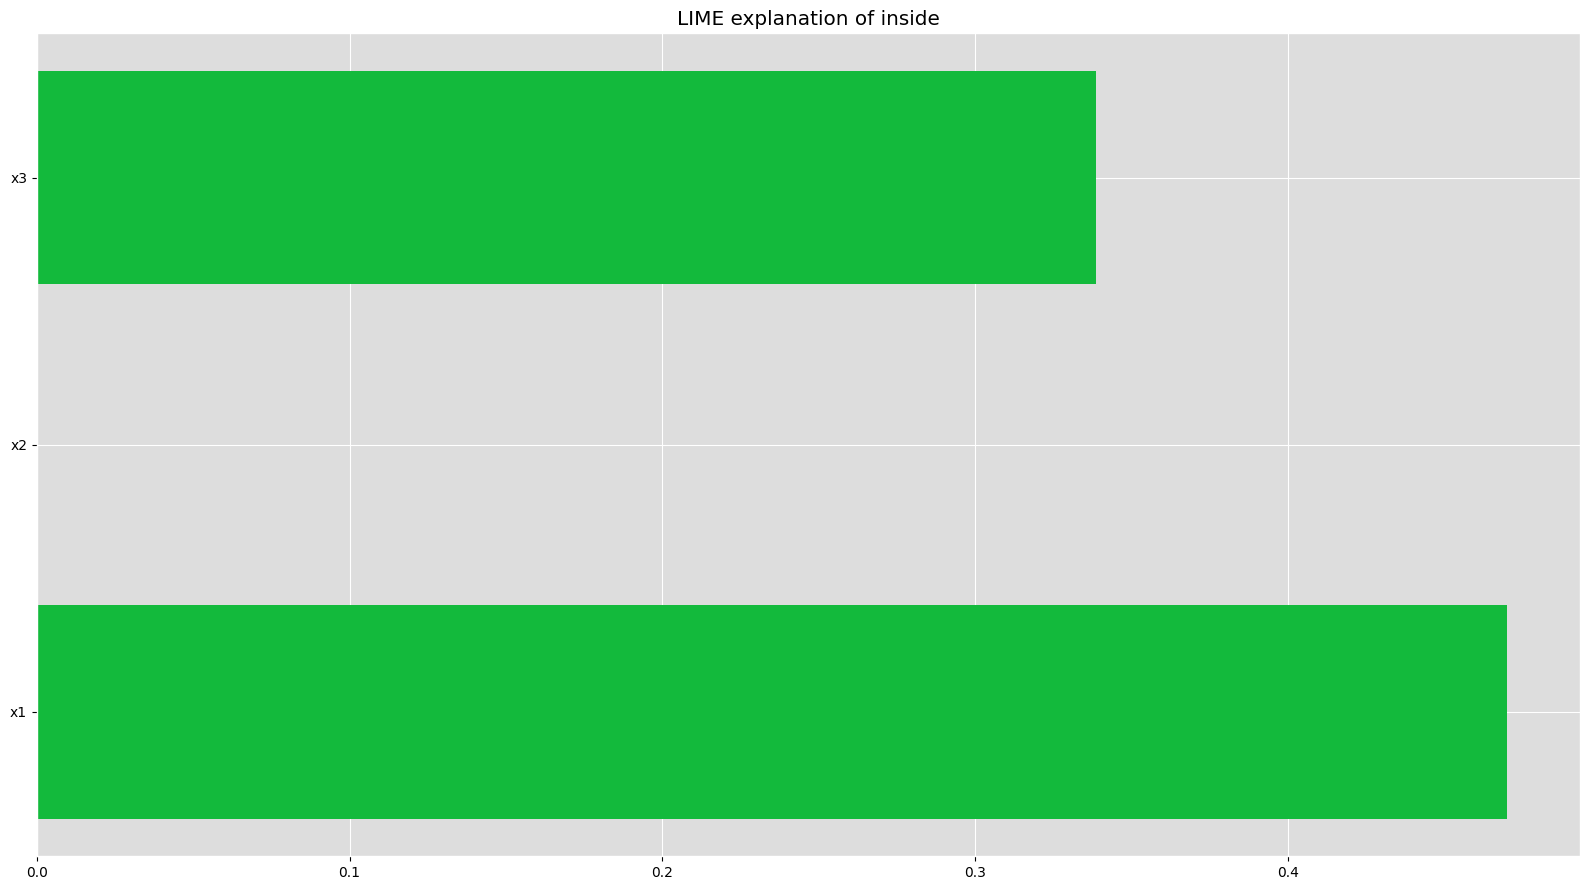

In [11]:
explanation.plot(decision)

## Using Python models



We will now show how to use a custom Python model with TrustyAI LIME implementation.

The model will be an XGBoost one trained with the `credit-bias` dataset.

For convenience, the model is pre-trained and serialised with `joblib` so that for this example we simply need to deserialised it.

In [12]:
import joblib

xg_model = joblib.load("models/credit-bias-xgboost.joblib")
print(xg_model)

/usr/local/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.07, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=12, num_parallel_tree=1, random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.9861206227457426,
              seed=27, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)


This model has as a single **output** a boolean `PaidLoan`, which will predict whether a certain loan applicant will repay the loan in time or not. The model is slightly more complex than the previous examples, with **input** features:

|Input feature         | Type    | Note        |
|----------------------|---------|-------------|
|`NewCreditCustomer`   |boolean  ||
|`Amount`              |numerical||
|`Interest`            |numerical||
|`LoanDuration`        |numerical|In months|
|`Education`           |numerical|Level (1, 2, 3..)|
|`NrOfDependants`      |numerical|Integer|
|`EmploymentDurationCurrentEmployer`|numerical|Integer (years)|
|`IncomeFromPrincipalEmployer`|numerical||
|`IncomeFromPension`   |numerical||
|`IncomeFromFamilyAllowance`|numerical||
|`IncomeFromSocialWelfare`|numerical||
|`IncomeFromLeavePay`|numerical||
|`IncomeFromChildSupport`|numerical||
|`IncomeOther`|numerical||
|`ExistingLiabilities`|numerical|integer|
|`RefinanceLiabilities`|numerical|integer|
|`DebtToIncome`|numerical||
|`FreeCash`|numerical||
|`CreditScoreEeMini`|numerical|integer|
|`NoOfPreviousLoansBeforeLoan`|numerical|integer|
|`AmountOfPreviousLoansBeforeLoan`|numerical||
|`PreviousRepaymentsBeforeLoan`|numerical||
|`PreviousEarlyRepaymentsBefoleLoan`|numerical||
|`PreviousEarlyRepaymentsCountBeforeLoan`|numerical|integer|
|`Council_house`|boolean||
|`Homeless`|boolean||
|`Joint_ownership`|boolean||
|`Joint_tenant`|boolean||
|`Living_with_parents`|boolean||
|`Mortgage`|boolean||
|`Other`|boolean||
|`Owner`|boolean||
|`Owner_with_encumbrance`|boolean||
|`Tenant`|boolean||
|`Entrepreneur`|boolean||
|`Fully`|boolean||
|`Partially`|boolean||
|`Retiree`|boolean||
|`Self_employed`|boolean||

Let's create and test a sample datapoint:

In [13]:
feature_values = {
        "NewCreditCustomer": False,
        "Amount": 2125.0,
        "Interest": 20.97,
        "LoanDuration": 60.0,
        "Education": 4.0,
        "NrOfDependants": 0.0,
        "EmploymentDurationCurrentEmployer": 6.0,
        "IncomeFromPrincipalEmployer": 0.0,
        "IncomeFromPension": 301.0,
        "IncomeFromFamilyAllowance": 0.0,
        "IncomeFromSocialWelfare": 53.0,
        "IncomeFromLeavePay": 0.0,
        "IncomeFromChildSupport": 0.0,
        "IncomeOther": 0.0,
        "ExistingLiabilities": 8.0,
        "RefinanceLiabilities": 6.0,
        "DebtToIncome": 26.29,
        "FreeCash": 10.92,
        "CreditScoreEeMini": 1000.0,
        "NoOfPreviousLoansBeforeLoan": 1.0,
        "AmountOfPreviousLoansBeforeLoan": 500.0,
        "PreviousRepaymentsBeforeLoan": 590.95,
        "PreviousEarlyRepaymentsBefoleLoan": 0.0,
        "PreviousEarlyRepaymentsCountBeforeLoan": 0.0,
        "Council_house": False,
        "Homeless": False,
        "Joint_ownership": False,
        "Joint_tenant": False,
        "Living_with_parents": False,
        "Mortgage": False,
        "Other": False,
        "Owner": False,
        "Owner_with_encumbrance": True,
        "Tenant": True,
        "Entrepreneur": False,
        "Fully": False,
        "Partially": False,
        "Retiree": True,
        "Self_employed": False
}

feature_df = pd.DataFrame([feature_values])
feature_df

,NewCreditCustomer,Amount,Interest,LoanDuration,Education,NrOfDependants,EmploymentDurationCurrentEmployer,IncomeFromPrincipalEmployer,IncomeFromPension,IncomeFromFamilyAllowance,...,Mortgage,Other,Owner,Owner_with_encumbrance,Tenant,Entrepreneur,Fully,Partially,Retiree,Self_employed
0,False,2125.0,20.97,60.0,4.0,0.0,6.0,0.0,301.0,0.0,...,False,False,False,True,True,False,False,False,True,False


We can see that this application will be rejected with a probability of $\sim77\%$:

In [14]:
import numpy as np

print(xg_model.predict_proba(feature_df))
print(f"Paid loan is predicted as: {xg_model.predict(feature_df)}")

[[0.7835957  0.21640435]]
Paid loan is predicted as: [False]


We will now prepare the XGBoost model to be used from the TrustyAI. Since our model outputs a Numpy array, we need to specify the column names of the output. Additionally, we must make sure our model's outputs are of shape `[n_inputs, n_outputs]`, which we can do by wrapping the model output into a DataFrame:

Once the prediction method is created, we wrap in a `Model` class.

This class takes care of all the JVM's asynchronous plumbing for us.

In [15]:
from trustyai.model import Model

model = Model(lambda x: pd.DataFrame(xg_model.predict(x), columns=['PaidLoan']))

We can confirm now, with the newly created `PredictionProvider` model that this input will lead to a `false` `PaidLoan` prediction:

In [16]:
output = model(feature_df)

We generate a prediction to be passed to the LIME explainer. We have to reshape the outputs, because the `simple_prediction` function expects the `output` argument
to be of shape ``[1, n_outputs]``.

In [17]:
from trustyai.model import simple_prediction

prediction = simple_prediction(input_features=feature_df, outputs=output)

We execute the LIME explainer on the XGBoost model and prediction

In [18]:
from trustyai.explainers import LimeExplainer

explainer = LimeExplainer(samples=100, perturbations=2, seed=23, normalise_weights=False)
explanation = explainer.explain(prediction, model)

We output the top 2 most important features for the prediction outcome

In [19]:
for f in explanation.map()['PaidLoan'].getTopFeatures(2):
    print(f)

FeatureImportance{feature=Feature{name='PreviousEarlyRepaymentsCountBeforeLoan', type=number, value=0.0}, score=-1.8207992602804817, confidence= +/-0.0}
FeatureImportance{feature=Feature{name='IncomeFromPrincipalEmployer', type=number, value=0.0}, score=-1.6037355291723934, confidence= +/-0.0}


In [20]:
explanation.as_dataframe()

,PaidLoan_features,PaidLoan_score,PaidLoan_value,PaidLoan_confidence
0,NewCreditCustomer,0.494151,0.00,0.0
1,Amount,0.646571,2125.00,0.0
2,Interest,-0.221954,20.97,0.0
3,LoanDuration,1.066822,60.00,0.0
4,Education,-0.186178,4.00,0.0
5,NrOfDependants,-0.102228,0.00,0.0
6,EmploymentDurationCurrentEmployer,1.123659,6.00,0.0
7,IncomeFromPrincipalEmployer,-1.603736,0.00,0.0
8,IncomeFromPension,-0.325927,301.00,0.0
9,IncomeFromFamilyAllowance,0.649004,0.00,0.0


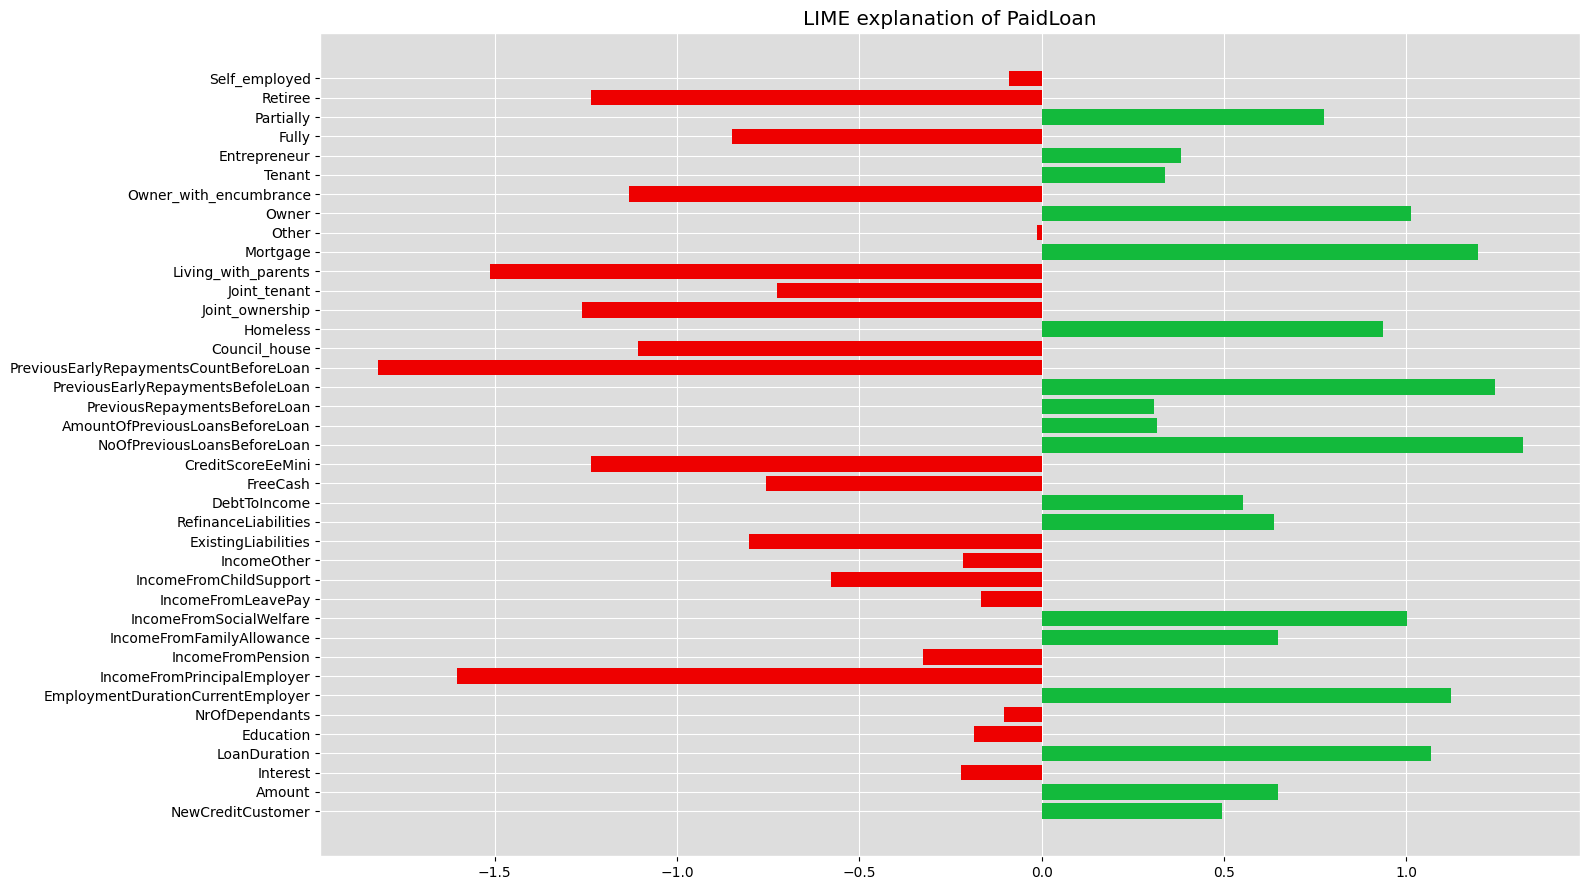

In [21]:
explanation.plot('PaidLoan')